In [1]:
import os
import numpy as np
import torch

In [12]:
from utils import load_model
model, _ = load_model('test_pretrained/tsp_20_few_samples/')
model.eval()  # Put in evaluation mode to not track gradients

xy = np.random.rand(20, 2)

def make_oracle(model, xy, temperature=1.0):
    
    num_nodes = len(xy)
    
    xyt = torch.tensor(xy).float()[None]  # Add batch dimension
    
    with torch.no_grad():  # Inference only
        embeddings, _ = model.embedder(model._init_embed(xyt))

        # Compute keys, values for the glimpse and keys for the logits once as they can be reused in every step
        fixed = model._precompute(embeddings)
    
    def oracle(tour):
        with torch.no_grad():  # Inference only
            # Input tour with 0 based indices
            # Output vector with probabilities for locations not in tour
            tour = torch.tensor(tour).long()
            if len(tour) == 0:
                step_context = model.W_placeholder
            else:
                step_context = torch.cat((embeddings[0, tour[0]], embeddings[0, tour[-1]]), -1)

            # Compute query = context node embedding, add batch and step dimensions (both 1)
            query = fixed.context_node_projected + model.project_step_context(step_context[None, None, :])

            # Create the mask and convert to bool depending on PyTorch version
            mask = torch.zeros(num_nodes, dtype=torch.uint8) > 0
            mask[tour] = 1
            mask = mask[None, None, :]  # Add batch and step dimension

            log_p, _ = model._one_to_many_logits(query, fixed.glimpse_key, fixed.glimpse_val, fixed.logit_key, mask)
            p = torch.softmax(log_p / temperature, -1)[0, 0]
            assert (p[tour] == 0).all()
            assert (p.sum() - 1).abs() < 1e-5
            #assert np.allclose(p.sum().item(), 1)
        return p.numpy()
    return oracle

  [*] Loading model from test_pretrained/tsp_20_few_samples/epoch-19.pt


In [4]:
# print(xy)
xy = np.array([[0.05984521, 0.32429765],
 [0.57938763, 0.1952789 ],
 [0.71915007, 0.55385031],
 [0.04710143, 0.92584545],
 [0.17471003, 0.75017482],
 [0.6168486,  0.69531069],
 [0.66628432, 0.88364989],
 [0.8691514,  0.48405367],
 [0.58757323, 0.93439758],
 [0.85300866, 0.19646063],
 [0.52209117, 0.15026675],
 [0.77777361, 0.51857109],
 [0.61371295, 0.58089916],
 [0.87884751, 0.69997751],
 [0.71906182, 0.76757071],
 [0.61359469, 0.47413394],
 [0.14900085, 0.20402469],
 [0.6970835,  0.07320967],
 [0.47305915, 0.98654559],
 [0.09569147, 0.1230548 ]])

In [13]:
import math
import numpy as np

# assump that the ratation direction is counterclockwise
def rotate_data(xy, theta=60):
    
    theta = math.radians(theta)
    sin = math.sin(theta)
    cos = math.cos(theta)
    
    rotation_matrix = [[cos, -sin],
                       [sin, cos]]
    rotation_xy = []
    for point in xy:
        rotation_xy.append(list(np.dot(rotation_matrix, point)))
        
    return np.array(rotation_xy)

def permute_data(xy):
    permutation_xy = xy.copy()
    np.random.shuffle(permutation_xy)
    return permutation_xy

def scale_data(xy, sigma=1.5):
    scale_xy = [i*sigma for i in xy]
    return np.array(scale_xy)

def translate_data(xy, vector_translation = [-0.5,-0.5]):
    translation_xy = [np.add(i,vector_translation) for i in xy]
    return np.array(translation_xy)

rotation_xy = rotate_data(xy)
permutation_xy = permute_data(xy)
scale_xy = scale_data(xy)
translation_xy = translate_data(xy)
# print(translation_xy)
# print(scale_xy)
# print(permutation_xy)



Rotation matrix in case of counter-clockwise


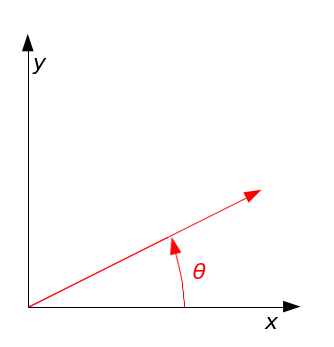

In [6]:
print("Rotation matrix in case of counter-clockwise")
from IPython import display
display.Image("https://upload.wikimedia.org/wikipedia/commons/d/d5/Counterclockwise_rotation.png")


In [14]:
def get_tour(model, xy):
    oracle = make_oracle(model, xy)

    sample = False
    tour = []
    tour_p = []
    while(len(tour) < len(xy)):
        p = oracle(tour)
        
        if sample:
            # Advertising the Gumbel-Max trick
            g = -np.log(-np.log(np.random.rand(*p.shape)))
            i = np.argmax(np.log(p) + g)
            # i = np.random.multinomial(1, p)
        else:
            # Greedy
            i = np.argmax(p)
        tour.append(i)
        tour_p.append(p)
    print(tour)
    return tour
tour = get_tour(model, xy)
rotation_tour = get_tour(model, rotation_xy)
permutation_tour = get_tour(model, permutation_xy)
scale_tour = get_tour(model, scale_xy)
translation_tour = get_tour(model, translation_xy)


[12, 16, 0, 4, 15, 3, 14, 11, 18, 13, 2, 8, 19, 9, 7, 1, 10, 6, 5, 17]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[14, 13, 12, 4, 2, 6, 3, 0, 7, 17, 18, 11, 19, 16, 9, 15, 1, 10, 8, 5]
[4, 0, 16, 15, 3, 14, 11, 18, 8, 19, 9, 13, 2, 10, 7, 1, 6, 17, 5, 12]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


In [10]:
# oracle = make_oracle(model, xy)

# sample = False
# tour = []
# tour_p = []
# while(len(tour) < len(xy)):
#     p = oracle(tour)
    
#     if sample:
#         # Advertising the Gumbel-Max trick
#         g = -np.log(-np.log(np.random.rand(*p.shape)))
#         i = np.argmax(np.log(p) + g)
#         # i = np.random.multinomial(1, p)
#     else:
#         # Greedy
#         i = np.argmax(p)
#     tour.append(i)
#     tour_p.append(p)
    
# print(tour)

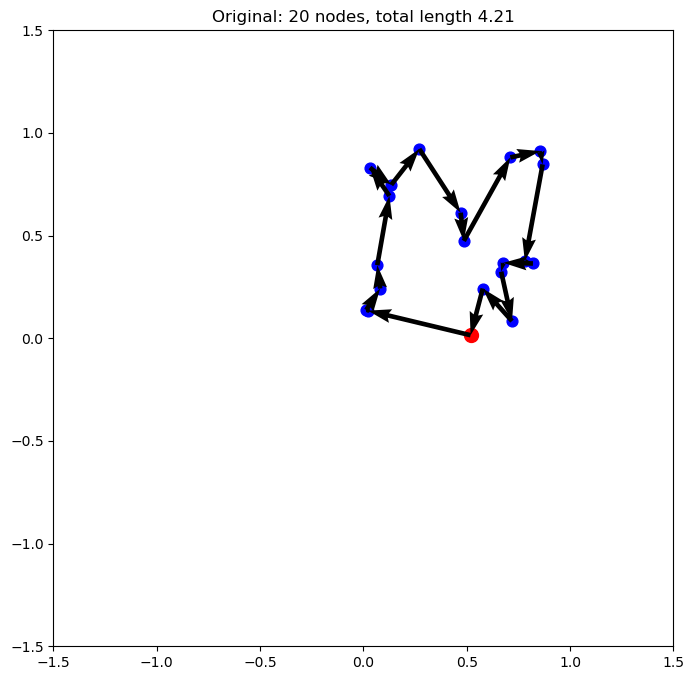

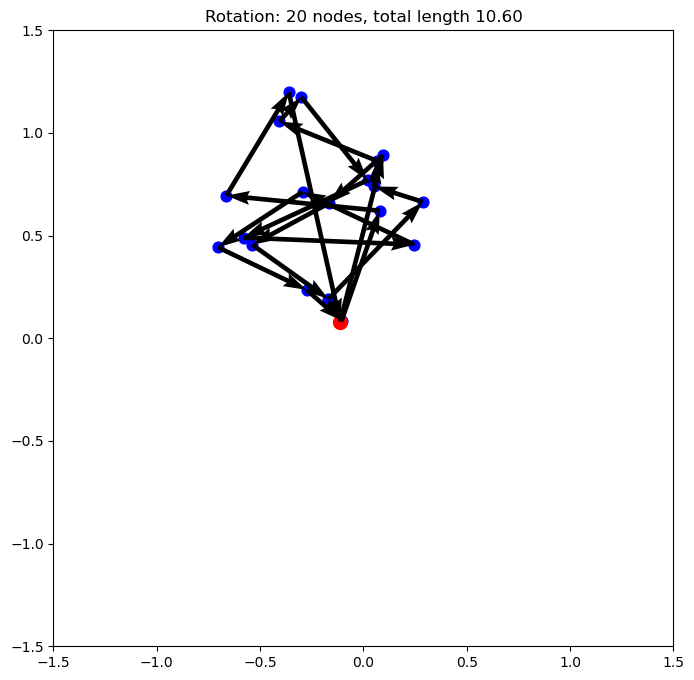

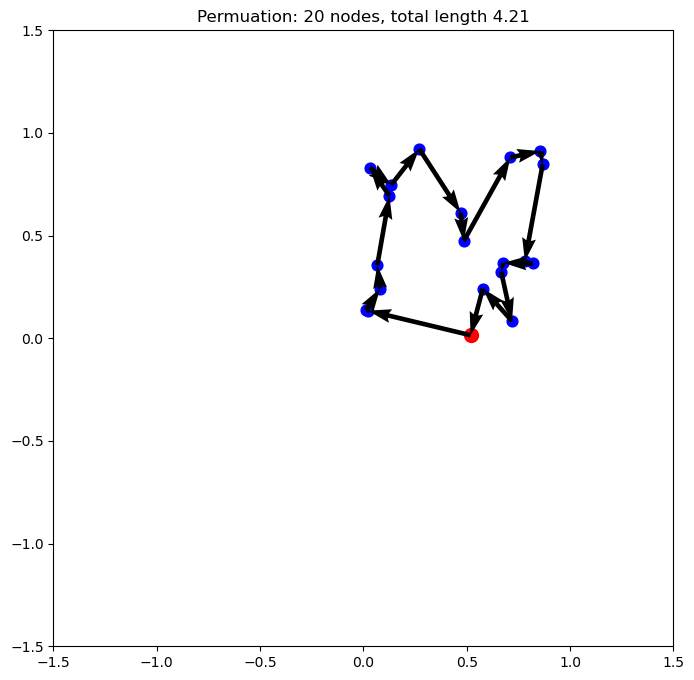

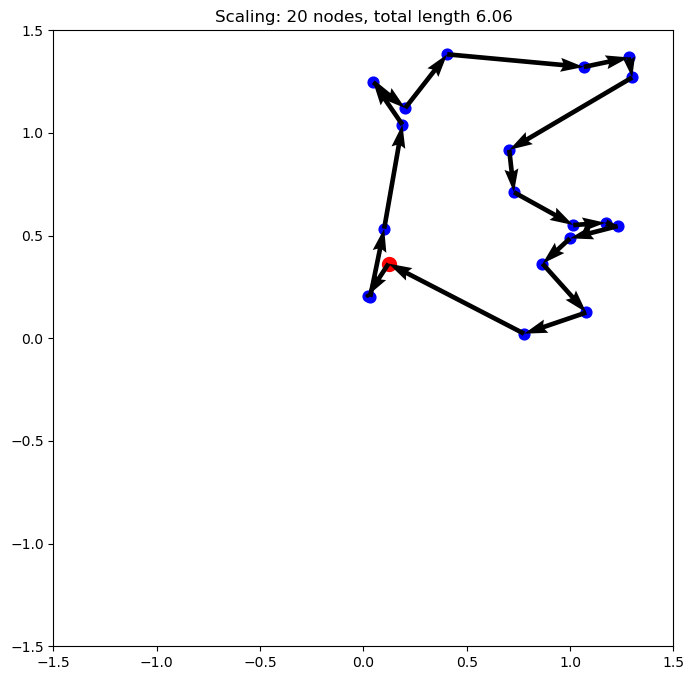

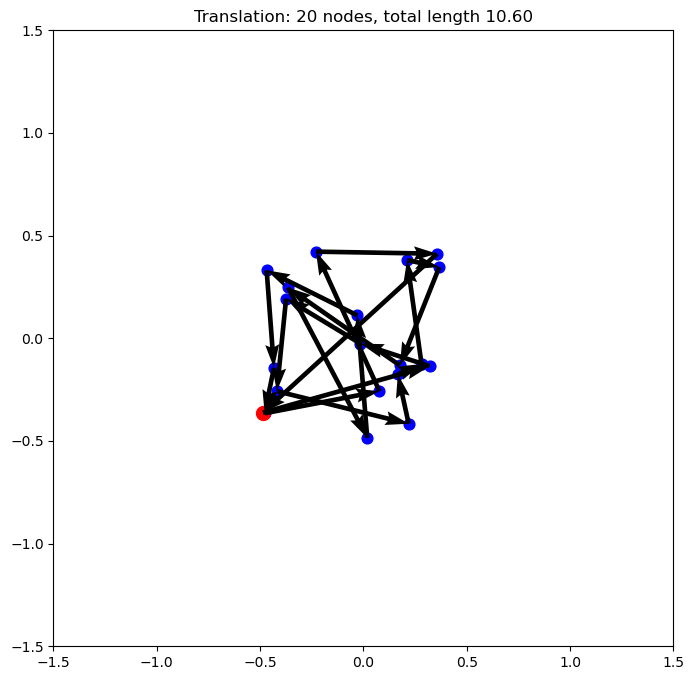

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Code inspired by Google OR Tools plot:
# https://github.com/google/or-tools/blob/fb12c5ded7423d524fc6c95656a9bdc290a81d4d/examples/python/cvrptw_plot.py

def plot_tsp(xy, tour, ax1, invariant):
    """
    Plot the TSP tour on matplotlib axis ax1.
    """
    
    ax1.set_xlim(-1.5, 1.5)
    ax1.set_ylim(-1.5, 1.5)
    
    xs, ys = xy[tour].transpose()
    # xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    # Scatter nodes
    ax1.scatter(xs, ys, s=60, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    
    ax1.set_title('{}: {} nodes, total length {:.2f}'.format(invariant, len(tour), lengths[-1]))
    

fig, ax = plt.subplots(figsize=(8, 8))
plot_tsp(xy, tour, ax, "Original")

fig, ax = plt.subplots(figsize=(8, 8))
plot_tsp(rotation_xy, rotation_tour, ax, "Rotation")

fig, ax = plt.subplots(figsize=(8, 8))
plot_tsp(permutation_xy, permutation_tour, ax, "Permuation")

fig, ax = plt.subplots(figsize=(8, 8))
plot_tsp(scale_xy, scale_tour, ax, "Scaling")

fig, ax = plt.subplots(figsize=(8, 8))
plot_tsp(translation_xy, translation_tour, ax, "Translation")


In [63]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from IPython.display import HTML

from celluloid import Camera  # pip install celluloid

def format_prob(prob):
    return ('{:.6f}' if prob > 1e-5 else '{:.2E}').format(prob)

def plot_tsp_ani(xy, tour, tour_p=None, max_steps=1000):
    n = len(tour)
    fig, ax1 = plt.subplots(figsize=(10, 10))
    xs, ys = xy[tour].transpose()
    dx = np.roll(xs, -1) - xs
    dy = np.roll(ys, -1) - ys
    d = np.sqrt(dx * dx + dy * dy)
    lengths = d.cumsum()
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)

    camera = Camera(fig)

    total_length = 0
    cum_log_prob = 0
    for i in range(n + 1):
        for plot_probs in [False] if tour_p is None or i >= n else [False, True]:
            # Title
            title = 'Nodes: {:3d}, length: {:.4f}, prob: {}'.format(
                i, lengths[i - 2] if i > 1 else 0., format_prob(np.exp(cum_log_prob))
            )
            ax1.text(0.6, 0.97, title, transform=ax.transAxes)

            # First print current node and next candidates
            ax1.scatter(xs, ys, s=40, color='blue')

            if i > 0:
                ax1.scatter([xs[i - 1]], [ys[i - 1]], s=100, color='red')
            if i > 1:
                qv = ax1.quiver(
                    xs[:i-1],
                    ys[:i-1],
                    dx[:i-1],
                    dy[:i-1],
                    scale_units='xy',
                    angles='xy',
                    scale=1,
                )
            if plot_probs:
                prob_rects = [Rectangle((x, y), 0.01, 0.1 * p) for (x, y), p in zip(xy, tour_p[i]) if p > 0.01]
                pc = PatchCollection(prob_rects, facecolor='lightgray', alpha=1.0, edgecolor='lightgray')
                ax1.add_collection(pc)
            camera.snap()
        if i < n and tour_p is not None:
            # Add cumulative_probability
            cum_log_prob += np.log(tour_p[i][tour[i]])
        if i > max_steps:
            break

    # Plot final tour
    # Scatter nodes
    ax1.scatter(xs, ys, s=40, color='blue')
    # Starting node
    ax1.scatter([xs[0]], [ys[0]], s=100, color='red')
    
    # Arcs
    qv = ax1.quiver(
        xs, ys, dx, dy,
        scale_units='xy',
        angles='xy',
        scale=1,
    )
    if tour_p is not None:
        # Note this does not use stable logsumexp trick
        cum_log_prob = format_prob(np.exp(sum([np.log(p[node]) for node, p in zip(tour, tour_p)])))
    else:
        cum_log_prob = '?'
    ax1.set_title('{} nodes, total length {:.4f}, prob: {}'.format(len(tour), lengths[-1], cum_log_prob))
    
    camera.snap()
    
    return camera 

    
animation = plot_tsp_ani(xy, tour, tour_p).animate(interval=500)
# animation.save('images/tsp.gif', writer='imagemagick', fps=2)  # requires imagemagick 
# compress by running 'convert tsp.gif -strip -coalesce -layers Optimize tsp.gif'
HTML(animation.to_html5_video())  # requires ffmpeg

ModuleNotFoundError: No module named 'celluloid'